In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Load data
df = pd.read_csv('BTC-USD_stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
# Predicr 'Close' column
data = df[['Close']]

# Split data by time
train_data = data[:'2022']
test_data = data['2023':]

In [ ]:
# Normalisasi hanya berdasarkan training (hindari data leakage)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Dataset class (untuk input sequence & target)
class BTCSequenceDataset(Dataset):
    def __init__(self, data, input_len=30, pred_len=7):
        self.data = data
        self.input_len = input_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.input_len - self.pred_len

    def __getitem__(self, idx):
      x = self.data[idx:idx + self.input_len]
      y = self.data[idx + self.input_len:idx + self.input_len + self.pred_len]
      return torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32)

In [ ]:
# Membuat dataset dan dataloader
input_len = 30
pred_len = 7

train_dataset = BTCSequenceDataset(train_scaled, input_len, pred_len)
test_dataset = BTCSequenceDataset(test_scaled, input_len, pred_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(1)

    def forward(self, x):
        x = x + self.pe[:x.size(0)].to(x.device)
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim, d_model=128, n_heads=8, e_layers=4, pred_len=7):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=0.2)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=e_layers)
        self.output_proj = nn.Linear(d_model, pred_len)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoding(x.permute(1, 0, 2))  # (seq_len, batch, d_model)
        encoded = self.encoder(x)
        output = self.output_proj(encoded[-1])  # Take last time step
        return output

In [ ]:
# Training Loop with fine-tuning and early stopping
model = Transformer(input_dim=1, d_model=32, n_heads=2, e_layers=1, pred_len=pred_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)
best_loss = float('inf')
patience = 5
wait = 0

for epoch in range(50):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        batch_x = batch_x.squeeze(-1)
        pred = model(batch_x)
        batch_y = batch_y.squeeze(-1)
        loss = criterion(pred, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.0393
Epoch 2, Loss: 0.0101
Epoch 3, Loss: 0.0063
Epoch 4, Loss: 0.0044
Epoch 5, Loss: 0.0035
Epoch 6, Loss: 0.0029
Epoch 7, Loss: 0.0025
Epoch 8, Loss: 0.0022
Epoch 9, Loss: 0.0019
Epoch 10, Loss: 0.0018
Epoch 11, Loss: 0.0016
Epoch 12, Loss: 0.0015
Epoch 13, Loss: 0.0014
Epoch 14, Loss: 0.0013
Epoch 15, Loss: 0.0013
Epoch 16, Loss: 0.0013
Epoch 17, Loss: 0.0012
Epoch 18, Loss: 0.0012
Epoch 19, Loss: 0.0011
Epoch 20, Loss: 0.0012
Epoch 21, Loss: 0.0011
Epoch 22, Loss: 0.0011
Epoch 23, Loss: 0.0011
Epoch 24, Loss: 0.0011
Epoch 25, Loss: 0.0011
Epoch 26, Loss: 0.0011
Epoch 27, Loss: 0.0010
Epoch 28, Loss: 0.0010
Epoch 29, Loss: 0.0010
Epoch 30, Loss: 0.0010
Epoch 31, Loss: 0.0010
Epoch 32, Loss: 0.0010
Epoch 33, Loss: 0.0009
Epoch 34, Loss: 0.0009
Epoch 35, Loss: 0.0010
Epoch 36, Loss: 0.0009
Epoch 37, Loss: 0.0009
Epoch 38, Loss: 0.0009
Epoch 39, Loss: 0.0009
Epoch 40, Loss: 0.0009
Epoch 41, Loss: 0.0009
Epoch 42, Loss: 0.0009
Epoch 43, Loss: 0.0009
Epoch 44, Loss: 0.00

In [ ]:
# Load best model sebelum testing
model.load_state_dict(torch.load('best_model.pt'))
print(model)

Transformer(
  (input_proj): Linear(in_features=1, out_features=32, bias=True)
  (pos_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (output_proj): Linear(in_features=32, out_features=7, bias=True)
)


In [ ]:
# Output Predictions
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.squeeze(-1)
        output = model(batch_x)
        predictions.append(output.squeeze().cpu().numpy())
        actuals.append(batch_y.squeeze().cpu().numpy())

In [ ]:
# Balikkan normalisasi
predictions = scaler.inverse_transform(np.array(predictions))
actuals = scaler.inverse_transform(np.array(actuals))

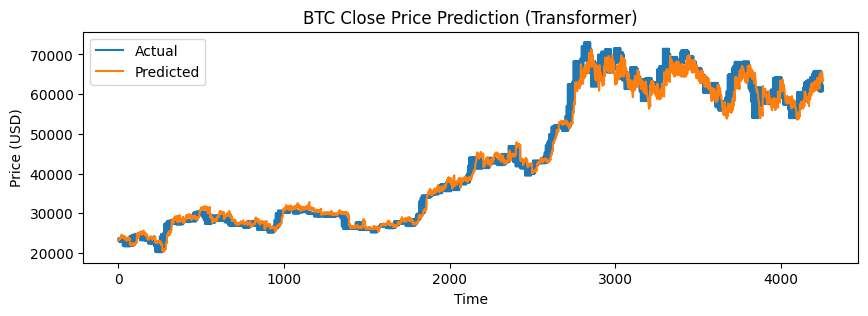

In [ ]:
# Visualisasi
plt.figure(figsize=(10, 3))
plt.plot(actuals.flatten(), label='Actual')
plt.plot(predictions.flatten(), label='Predicted')
plt.legend()
plt.title('BTC Close Price Prediction (Transformer)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.show()

In [ ]:
# Helper functions for additional metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

# Evaluation
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, predictions)
mape_val = mape(actuals, predictions)
smape_val = smape(actuals, predictions)
rmsle_val = rmsle(actuals, predictions)

# Display metrics
print(f"Evaluation Metrics")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")
print(f"MAPE  : {mape_val:.4f}%")
print(f"SMAPE : {smape_val:.4f}%")
print(f"RMSLE : {rmsle_val:.4f}\n")

Evaluation Metrics
MAE   : 1754.5848
MSE   : 6214428.5000
RMSE  : 2492.8755
R²    : 0.9777
MAPE  : 3.9790%
SMAPE : 3.9942%
RMSLE : 0.0528



## Reference
https://www.kaggle.com/datasets/gallo33henrique/bitcoin-btc-usd-stock-dataset